# Comparison of solvers

This notebook shows how to estimate the counterfactual with Scipy and PyMC5 and creates comparison plots

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from attrici.detrend import Config, detrend
from pathlib import Path

from loguru import logger

logger.remove()

## Estimation and comparison to desired/target data

In [2]:
variable_name = "tas"

## PyMC5 run

In [3]:
config = Config(
    gmt_file=Path("../tests/data/20CRv3-ERA5_germany_ssa_gmt.nc"),
    input_file=Path("../tests/data/20CRv3-ERA5_germany_obs.nc"),
    mask_file=Path("../tests/data/mask_lat50.75_lon9.25.nc"),
    variable=variable_name,
    output_dir=Path("../tests/data/output/pymc5"),
    overwrite=True,
    report_variables=["ds", "y", "cfact"],
    solver="pymc5",
    stop_date="2021-12-31",
)
detrend(config)

data_pymc5 = pd.read_hdf(
    f"../tests/data/output/pymc5/timeseries/{variable_name}/lat_50.75/ts_lat50.75_lon9.25.h5"
)
data_pymc5["time"] = data_pymc5.ds
data_pymc5.index = data_pymc5.time

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/robert/Projects/attrici/attrici-private/env/lib/python3.12/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'lat_50.75_lon_9.25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## Scipy run

In [4]:
config = Config(
    gmt_file=Path("../tests/data/20CRv3-ERA5_germany_ssa_gmt.nc"),
    input_file=Path("../tests/data/20CRv3-ERA5_germany_obs.nc"),
    mask_file=Path("../tests/data/mask_lat50.75_lon9.25.nc"),
    variable=variable_name,
    output_dir=Path("../tests/data/output/scipy"),
    overwrite=True,
    report_variables=["ds", "y", "cfact"],
    solver="scipy",
    stop_date="2021-12-31",
)
detrend(config)

data_scipy = pd.read_hdf(
    f"../tests/data/output/scipy/timeseries/{variable_name}/lat_50.75/ts_lat50.75_lon9.25.h5"
)
data_scipy["time"] = data_scipy.ds
data_scipy.index = data_scipy.time

/home/robert/Projects/attrici/attrici-private/env/lib/python3.12/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'lat_50.75_lon_9.25'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Now load the target ('desired') data and store both `desired` and `scipy` counterfactuals in the date frame:

In [5]:
data = pd.read_hdf(
    f"../tests/data/20CRv3-ERA5_germany_target_{variable_name}_lat50.75_lon9.25.h5"
)
data["time"] = data.ds
data.index = data.time
data["desired"] = data.cfact
data["pymc5"] = data_pymc5.cfact.values
data["scipy"] = data_scipy.cfact.values

### Differences

Differences between both time series (actual and desired) are:

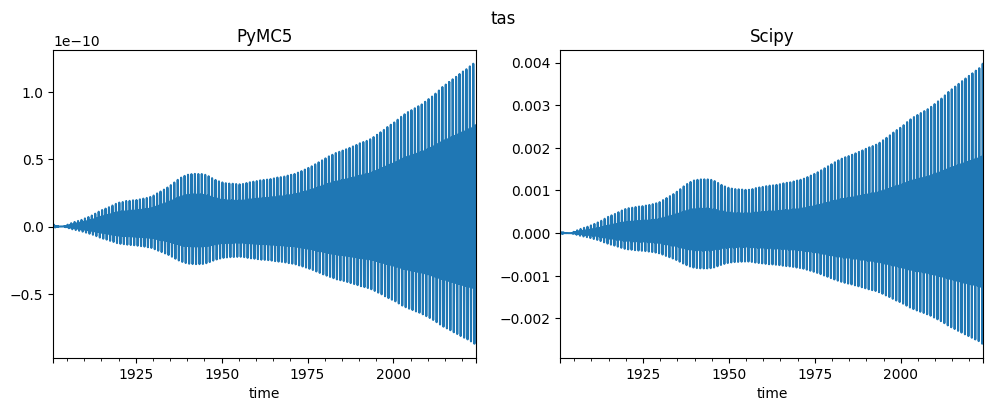

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(variable_name)
ax[0].set_title("PyMC5")
ax[1].set_title("Scipy")
(data.desired - data.pymc5).plot(ax=ax[0])
(data.desired - data.scipy).plot(ax=ax[1]);

A single year for comparison

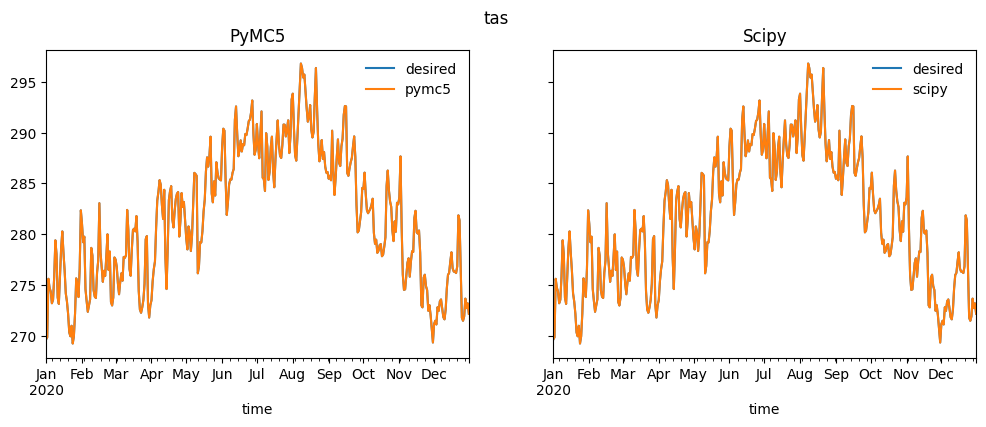

In [7]:
year = "2020"

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle(variable_name)
ax[0].set_title("PyMC5")
ax[1].set_title("Scipy")

data.desired.loc[year].plot(ax=ax[0], label="desired")
data.pymc5.loc[year].plot(ax=ax[0], label="pymc5")
ax[0].legend(frameon=False)
data.desired.loc[year].plot(ax=ax[1], label="desired")
data.scipy.loc[year].plot(ax=ax[1], label="scipy")
ax[1].legend(frameon=False);

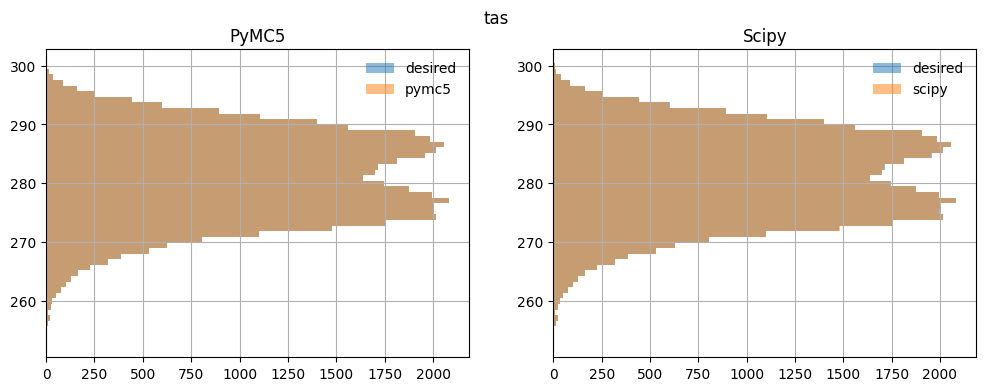

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(variable_name)
ax[0].set_title("PyMC5")
ax[1].set_title("Scipy")

data.desired.hist(
    ax=ax[0], bins=50, label="desired", orientation="horizontal", alpha=0.5
)
data.pymc5.hist(ax=ax[0], bins=50, label="pymc5", orientation="horizontal", alpha=0.5)
ax[0].legend(frameon=False)
data.desired.hist(
    ax=ax[1], bins=50, label="desired", orientation="horizontal", alpha=0.5
)
data.scipy.hist(ax=ax[1], bins=50, label="scipy", orientation="horizontal", alpha=0.5)
ax[1].legend(frameon=False);